In [1]:
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline 
import numpy as np
import pandas as pd
import os
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose
import xlrd
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [2]:
# Importing all climate data
DATA_PATH = './data/treated/csv'

df_humid_1h = pd.read_csv(os.path.join(DATA_PATH, 'humidity.csv'), index_col='date', parse_dates = ['date'])
df_pres_1h = pd.read_csv(os.path.join(DATA_PATH, 'pressure.csv'), index_col='date', parse_dates = ['date'])
df_rad_1d = pd.read_csv(os.path.join(DATA_PATH, 'radiation.csv'), index_col='date', parse_dates = ['date'])
df_wind_1h = pd.read_csv(os.path.join(DATA_PATH, 'wind.csv'), index_col='date', parse_dates = ['date'])
df_wet_temp_1h = pd.read_csv(os.path.join(DATA_PATH, 'wet_temperature.csv'), index_col='date', parse_dates = ['date'])
df_dry_temp_1h = pd.read_csv(os.path.join(DATA_PATH, 'dry_temperature.csv'), index_col='date', parse_dates = ['date'])
df_electric_15m = pd.read_csv(os.path.join(DATA_PATH, 'electric_consumption.csv'), index_col='date', parse_dates = ['date'])


# Tratando os dados de consumo

In [3]:
df_electric_15m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65960 entries, 2006-01-13 09:45:00 to 2007-12-05 13:30:00
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   demand_replacement  65960 non-null  int64  
 1   reactive_delay      65960 non-null  int64  
 2   station             65960 non-null  object 
 3   ep_kwh              65960 non-null  float64
 4   eq_kvarh            65960 non-null  float64
 5   p_kw                65960 non-null  float64
 6   q_kvar              65960 non-null  float64
 7   s_kva               65960 non-null  float64
 8   fp                  65960 non-null  float64
 9   fph                 65960 non-null  float64
 10  corr_kvar           65960 non-null  float64
 11  corrh_kvar          65960 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 6.5+ MB


Start date:  2006-01-13 09:45:00
End date:    2007-12-05 13:30:00


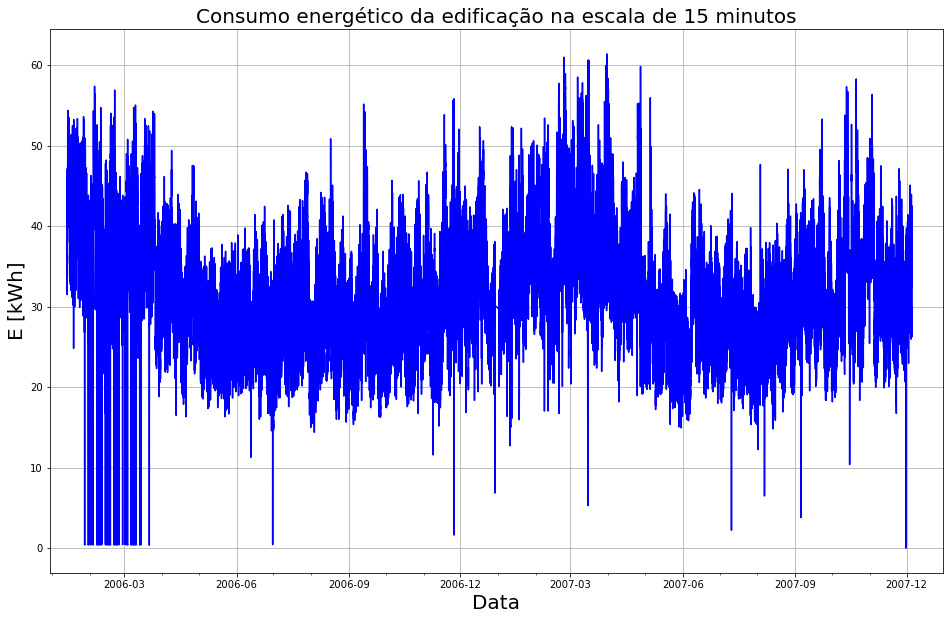

In [4]:
# Plotando o consumo energético da edificação
start_date = df_electric_15m.index.min()
end_date = df_electric_15m.index.max()

# Setting the plot
print("Start date: ", start_date)
print("End date:   ", end_date)

fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=30 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
ax.plot(df_electric_15m.index, df_electric_15m['ep_kwh'], color='blue')
ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo energético da edificação na escala de 15 minutos", fontsize=20)

ax.grid(True)
plt.show()

Count of trimmed values:  547


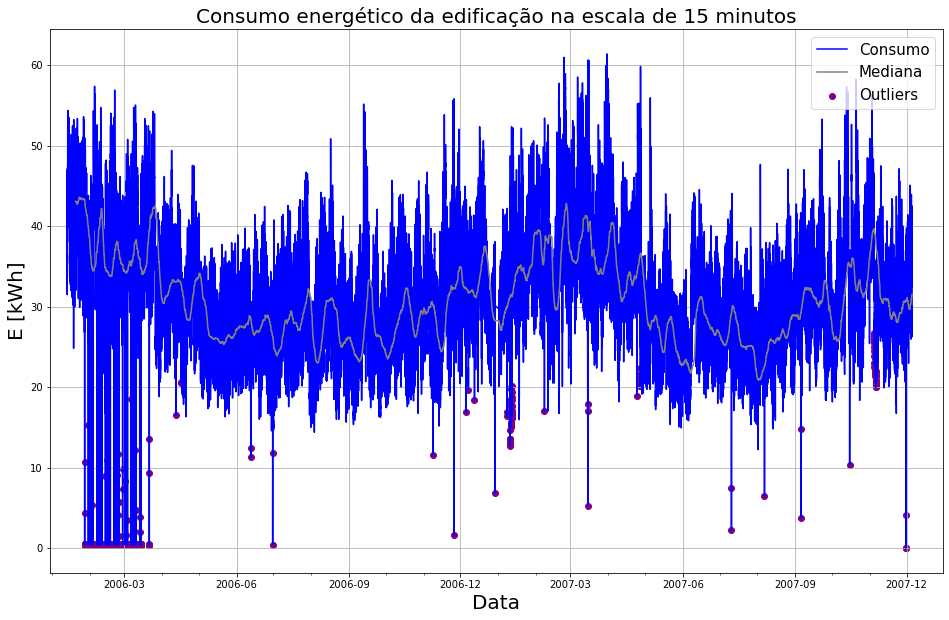

In [5]:
# Identifying outliers on the data 
# Applying a rolling window and getting the median
days = 7
window = (60//15)*24*days # Rolling window of 12 hours
amp_threshold = 7
min_threshhold = 7


roll = df_electric_15m['ep_kwh'].rolling(window)

# Applying an running MAD: median absolute deviation from the median.
# This is a strongly robust measure of variation within the data, akin to a standard deviation.
# An outlying peak would be several MADs or more greater than the median.
df_electric_15m['median'] = roll.median()
# df_electric_15m['upper_bound'] = roll.median() + 2*amp_threshold * ((df_electric_15m['ep_kwh'] - df_electric_15m['median']).abs()).median()
# df_electric_15m['lower_bound'] = roll.median() - amp_threshold * ((df_electric_15m['ep_kwh'] - df_electric_15m['median']).abs()).median()

# Trimming outliers by the normal curve
df_electric_15m['mean'] = roll.mean()
# df_electric_15m['upper_bound'] = roll.mean() + 4*((df_electric_15m['ep_kwh'] - df_electric_15m['mean'])).std()
# df_electric_15m['lower_bound'] = roll.mean() - 2*((df_electric_15m['ep_kwh'] - df_electric_15m['mean'])).std()

# Trimming outliers by quantile
Q1 = roll.quantile(0.25)
Q3 = roll.quantile(0.75)
IQR = Q3 - Q1

df_electric_15m['upper_bound'] = Q3 + 1.5*IQR
df_electric_15m['lower_bound'] = Q1 - 1.5*IQR

#mask_outliers = ((df_electric_15m['ep_kwh'] > df_electric_15m['upper_bound']) |
#                 (df_electric_15m['ep_kwh'] < df_electric_15m['lower_bound']) |
#                 (df_electric_15m['ep_kwh'] < min_threshhold))

mask_outliers = ((df_electric_15m['ep_kwh'] < df_electric_15m['lower_bound']) |
                (df_electric_15m['ep_kwh'] < min_threshhold))

print("Count of trimmed values: ", mask_outliers.sum())

# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=30 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
#ax.plot(df_electric_15m.index, df_electric_15m['lower_bound'], label='Lower')
#ax.plot(df_electric_15m.index, df_electric_15m['upper_bound'], label='Upper')
ax.plot(df_electric_15m.index, df_electric_15m['ep_kwh'], color='blue', label='Consumo')
ax.plot(df_electric_15m.index, df_electric_15m['median'], color='grey', label='Mediana')
# ax.plot(df_electric_15m.index, df_electric_15m['mean'], color='grey', label='Mean')
ax.scatter(df_electric_15m.loc[mask_outliers].index, df_electric_15m.loc[mask_outliers,'ep_kwh'], color='purple', label='Outliers')


ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo energético da edificação na escala de 15 minutos", fontsize=20)

ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()

Minimum value found:  0.36


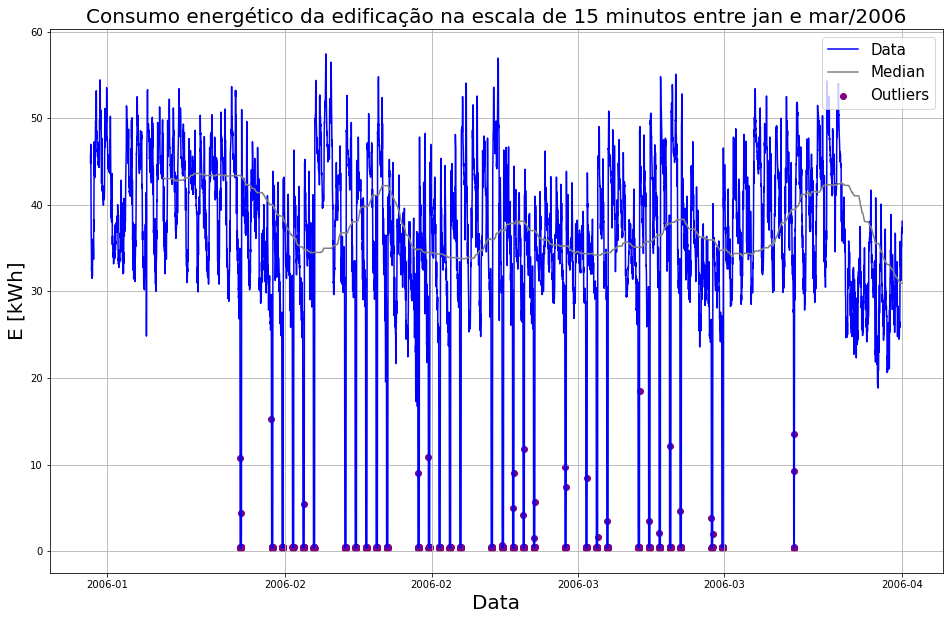

In [6]:
# PLotting a smaller window for visualization
date_interval = df_electric_15m.loc['2006-01':'2006-03']
print("Minimum value found: ", date_interval['ep_kwh'].min())

# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.plot(df_electric_15m.index, df_electric_15m['lower_bound'], label='Lower')
#ax.plot(df_electric_15m.index, df_electric_15m['upper_bound'], label='Upper')
ax.plot(date_interval.index, date_interval['ep_kwh'], color='blue', label='Data')
ax.plot(date_interval.index, date_interval['median'], color='grey', label='Median')
ax.scatter(date_interval.loc[mask_outliers].index, date_interval.loc[mask_outliers,'ep_kwh'], color='purple', label='Outliers')

ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo energético da edificação na escala de 15 minutos entre jan e mar/2006", fontsize=20)
ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()

In [7]:
# Defining a Time index
time_15m = pd.date_range(start=start_date, end=end_date, freq="15T", name='date')

total_size = time_15m.shape[0]
actual_size = df_electric_15m.shape[0]

nulls = (total_size-actual_size)

nulls_perc = nulls/total_size
print("Nº de nulos: ", nulls)
print("% de nulos: {:f}%".format(nulls_perc*100))

Nº de nulos:  392
% de nulos: 0.590789%


In [8]:


df_elec_15m_trim_outliers = df_electric_15m.loc[~mask_outliers]

df_elec_15m_trim_outliers.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65413 entries, 2006-01-13 09:45:00 to 2007-12-05 13:30:00
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   demand_replacement  65413 non-null  int64  
 1   reactive_delay      65413 non-null  int64  
 2   station             65413 non-null  object 
 3   ep_kwh              65413 non-null  float64
 4   eq_kvarh            65413 non-null  float64
 5   p_kw                65413 non-null  float64
 6   q_kvar              65413 non-null  float64
 7   s_kva               65413 non-null  float64
 8   fp                  65413 non-null  float64
 9   fph                 65413 non-null  float64
 10  corr_kvar           65413 non-null  float64
 11  corrh_kvar          65413 non-null  float64
 12  median              64742 non-null  float64
 13  mean                64742 non-null  float64
 14  upper_bound         64742 non-null  float64
 15  lower_bound       

In [9]:
df_elec_15m_trim_outliers = df_elec_15m_trim_outliers[['ep_kwh']]

df_elec_15m_trim_outliers = df_elec_15m_trim_outliers.reindex(time_15m)

df_elec_15m_trim_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66352 entries, 2006-01-13 09:45:00 to 2007-12-05 13:30:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ep_kwh  65413 non-null  float64
dtypes: float64(1)
memory usage: 1.0 MB


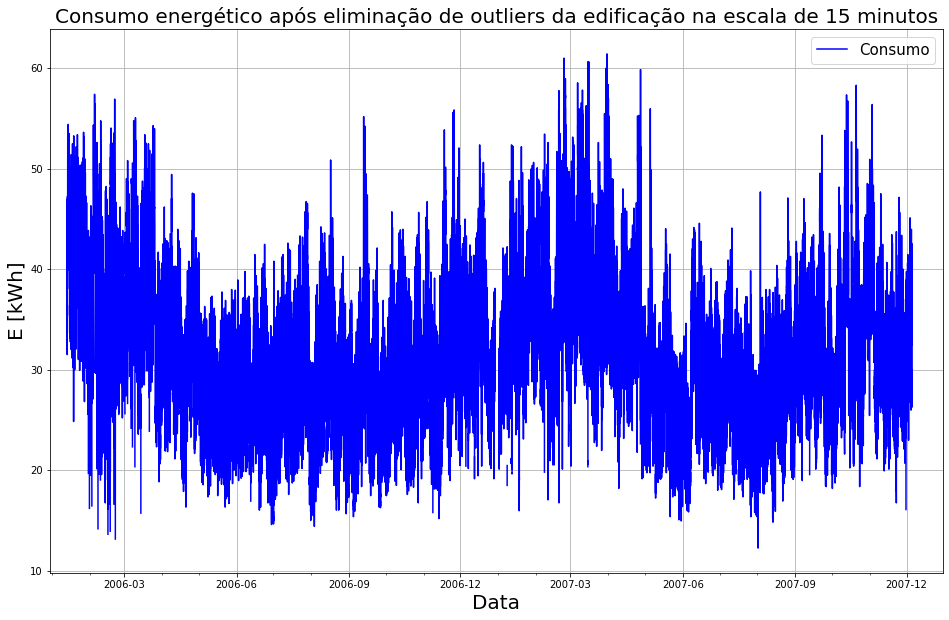

In [10]:
# Plotting the treated consumption
# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=30 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
ax.plot(df_elec_15m_trim_outliers.index, df_elec_15m_trim_outliers, color='blue', label='Consumo')

ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo energético após eliminação de outliers da edificação na escala de 15 minutos", fontsize=20)

ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()


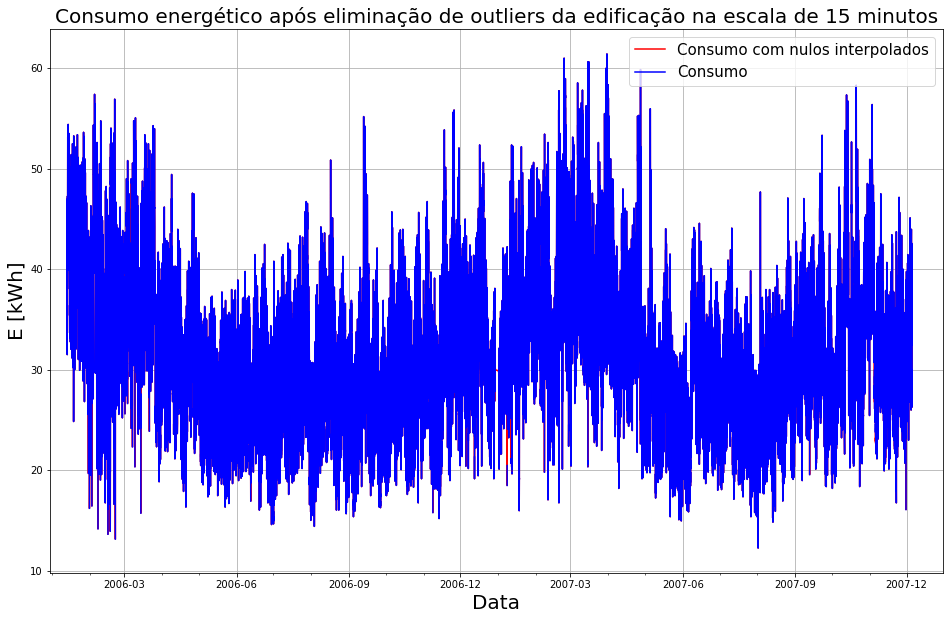

In [11]:
# df_elec_15m_trim_outliers_int = df_elec_15m_trim_outliers.interpolate(method='piecewise_polynomial', order=3)
df_elec_15m_trim_outliers_int = df_elec_15m_trim_outliers.interpolate(method='pchip')


# Plotting the treated consumption
# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=30 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
ax.plot(df_elec_15m_trim_outliers_int.index, df_elec_15m_trim_outliers_int, color='r', label='Consumo com nulos interpolados')
ax.plot(df_elec_15m_trim_outliers.index, df_elec_15m_trim_outliers, color='blue', label='Consumo')

ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo energético após eliminação de outliers da edificação na escala de 15 minutos", fontsize=20)

ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()

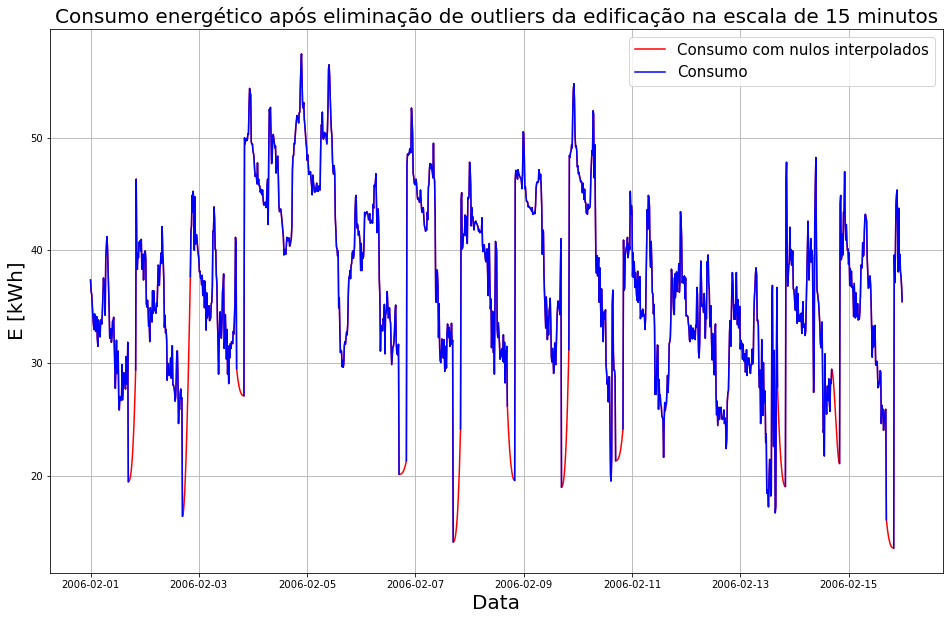

In [12]:
start_filter = '2006-02-01'
end_filter = '2006-02-15'

# Plotting the treated consumption
# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


# Plotting data
ax.plot(df_elec_15m_trim_outliers_int.loc[start_filter:end_filter].index, df_elec_15m_trim_outliers_int.loc[start_filter:end_filter], color='r', label='Consumo com nulos interpolados')
ax.plot(df_elec_15m_trim_outliers.loc[start_filter:end_filter].index, df_elec_15m_trim_outliers.loc[start_filter:end_filter], color='blue', label='Consumo')

ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo energético após eliminação de outliers da edificação na escala de 15 minutos", fontsize=20)

ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()

# Analisando os dados de consumo

In [13]:
df_elec_hour = df_elec_15m_trim_outliers['ep_kwh'].resample('H').sum()  # Summing the electricity consumption
#df_elec_hour.loc['2006'].groupby(df_elec_hour.loc['2006'].index.hour).mean().head()

df_elec_hour.shape

(16589,)

<bound method NDFrame._add_numeric_operations.<locals>.min of date
0     143.735966
1     132.934602
2     125.709545
3     121.952727
4     119.208409
5     118.366023
6     120.501307
7     125.542841
8     127.184659
9     126.922330
10    125.352578
11    127.147309
12    116.266062
13    104.714278
14     99.347082
15     98.625212
16     98.796884
17     96.281473
18    100.636657
19    116.937110
20    130.642096
21    139.647705
22    146.352408
23    150.051161
Name: ep_kwh, dtype: float64> <bound method NDFrame._add_numeric_operations.<locals>.min of date
0     140.073097
1     132.718761
2     124.486903
3     118.383186
4     115.403186
5     112.767257
6     114.368319
7     122.335044
8     132.971858
9     133.119292
10    135.476106
11    129.238584
12    121.205841
13    115.340769
14    108.556686
15    104.607692
16    104.782189
17    108.517101
18    114.783195
19    129.341183
20    138.915621
21    143.111006
22    147.286686
23    145.819882
Name: ep_kwh, dtype:

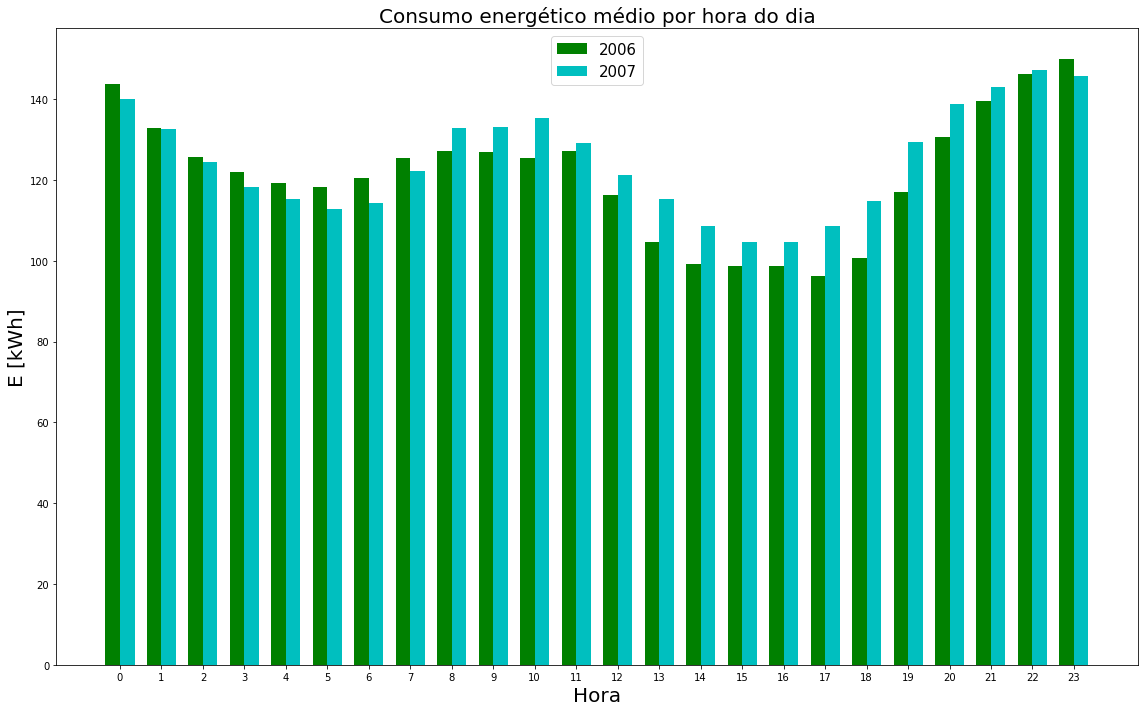

In [14]:
# Resampling to a daily sampling period
df_elec_hour = df_elec_15m_trim_outliers['ep_kwh'].resample('H').sum()  # Summing the electricity consumption
df_elec_hour = df_elec_hour.iloc[1:-1] # Excluindo dados da primeira e última horas

hours = np.arange(0,24)

hourly_avg_consumption_2006 = df_elec_hour.loc['2006'].groupby(df_elec_hour.loc['2006'].index.hour).mean()
hourly_avg_consumption_2007 = df_elec_hour.loc['2007'].groupby(df_elec_hour.loc['2007'].index.hour).mean()

width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(16, 10))

# Plotting data
ax.bar(hours, hourly_avg_consumption_2006, width=width,color='g', label = '2006')
ax.bar(hours+width, hourly_avg_consumption_2007,width=width ,color='c', label='2007')

ax.set_xlabel("Hora",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo energético médio por hora do dia", fontsize=20)

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(hours + width / 2)
ax.set_xticklabels(hours)

ax.legend(fontsize=15)
fig.tight_layout()

print(hourly_avg_consumption_2006.min, hourly_avg_consumption_2007.min)
print(hourly_avg_consumption_2006.max, hourly_avg_consumption_2007.max)

plt.show()

In [15]:
# Resampling to a daily sampling period
df_electric_h = df_elec_15m_trim_outliers_int['ep_kwh'].resample('H').sum()  # Summing the electricity consumption
df_electric_h = df_electric_h.iloc[1:-1] # Excluindo dados do primeiro e último dias

In [16]:
# Resampling to a daily sampling period
df_electric = df_elec_15m_trim_outliers_int['ep_kwh'].resample('D').sum()  # Summing the electricity consumption
df_electric = df_electric.iloc[1:-1] # Excluindo dados do primeiro e último dias

date
0    2773.477441
1    2820.807020
2    2914.436904
3    2976.240793
4    3072.094388
5    3189.273544
6    3003.734738
Name: ep_kwh, dtype: float64
date
0    2855.954151
1    2837.584493
2    2904.414701
3    2979.953769
4    3105.290872
5    3288.689375
6    3120.596717
Name: ep_kwh, dtype: float64


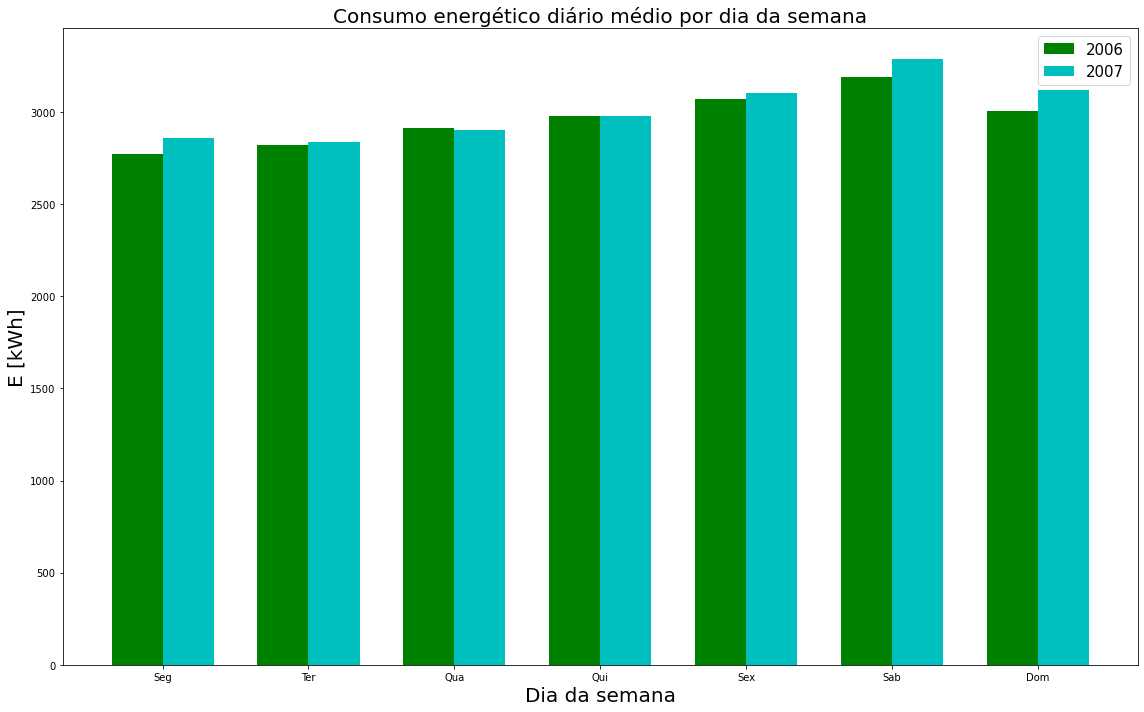

In [17]:
days = ['Seg','Ter','Qua','Qui','Sex','Sab', 'Dom']

daily_avg_consumption_2006 = df_electric.loc['2006'].groupby(df_electric.loc['2006'].index.weekday).mean()
daily_avg_consumption_2007 = df_electric.loc['2007'].groupby(df_electric.loc['2007'].index.weekday).mean()

ind = np.arange(7)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(16, 10))

# Plotting data
ax.bar(ind, daily_avg_consumption_2006, width=width,color='g', label = '2006')
ax.bar(ind+width, daily_avg_consumption_2007,width=width ,color='c', label='2007')

ax.set_xlabel("Dia da semana",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo energético diário médio por dia da semana", fontsize=20)

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(days)

ax.legend(fontsize=15)
fig.tight_layout()

print(daily_avg_consumption_2006)
print(daily_avg_consumption_2007)

plt.show()

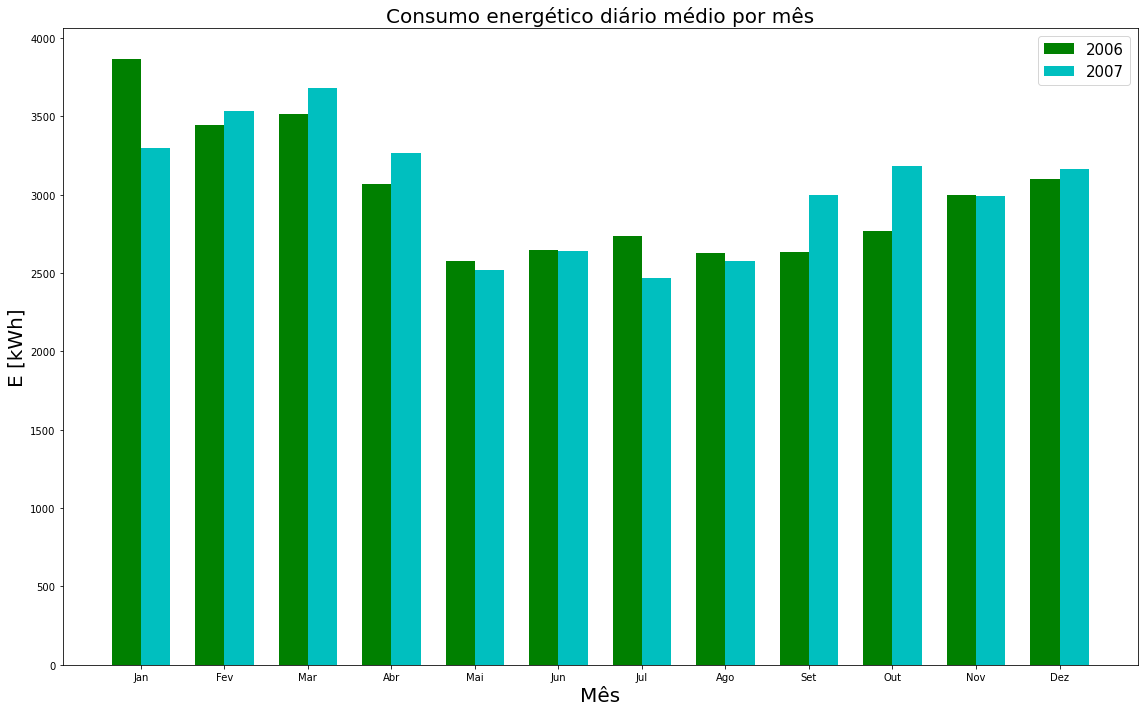

In [18]:
months = ['Jan','Fev','Mar','Abr','Mai','Jun', 'Jul', 'Ago','Set','Out','Nov','Dez']

monthly_avg_consumption_2006 = df_electric.loc['2006'].groupby(df_electric.loc['2006'].index.month).mean()
monthly_avg_consumption_2007 = df_electric.loc['2007'].groupby(df_electric.loc['2007'].index.month).mean()

ind = np.arange(12)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(16, 10))

# Plotting data
ax.bar(ind, monthly_avg_consumption_2006, width=width,color='g', label = '2006')
ax.bar(ind+width, monthly_avg_consumption_2007,width=width ,color='c', label='2007')

ax.set_xlabel("Mês",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo energético diário médio por mês", fontsize=20)

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(months)

ax.legend(fontsize=15)
fig.tight_layout()

plt.show()


No handles with labels found to put in legend.


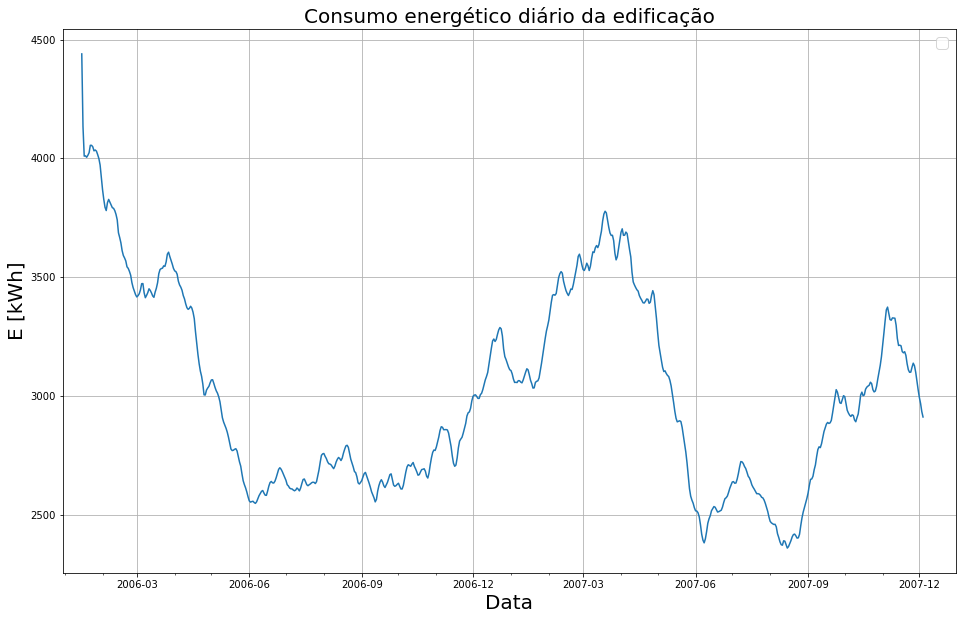

In [19]:
# Plotting the daily treated consumption
# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=30 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
ax.plot(df_electric.rolling('30d', closed='left').mean())

ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo energético diário da edificação", fontsize=20)

ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()

<AxesSubplot:xlabel='date'>

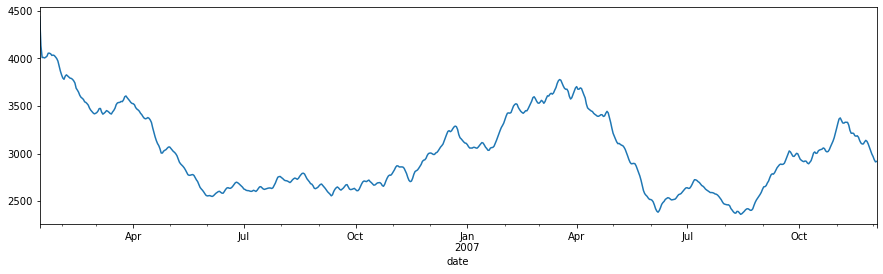

In [20]:
# Plotting a rolling avg of the electrical consumption

df_electric.rolling('30d').mean().plot(figsize=(15,4))

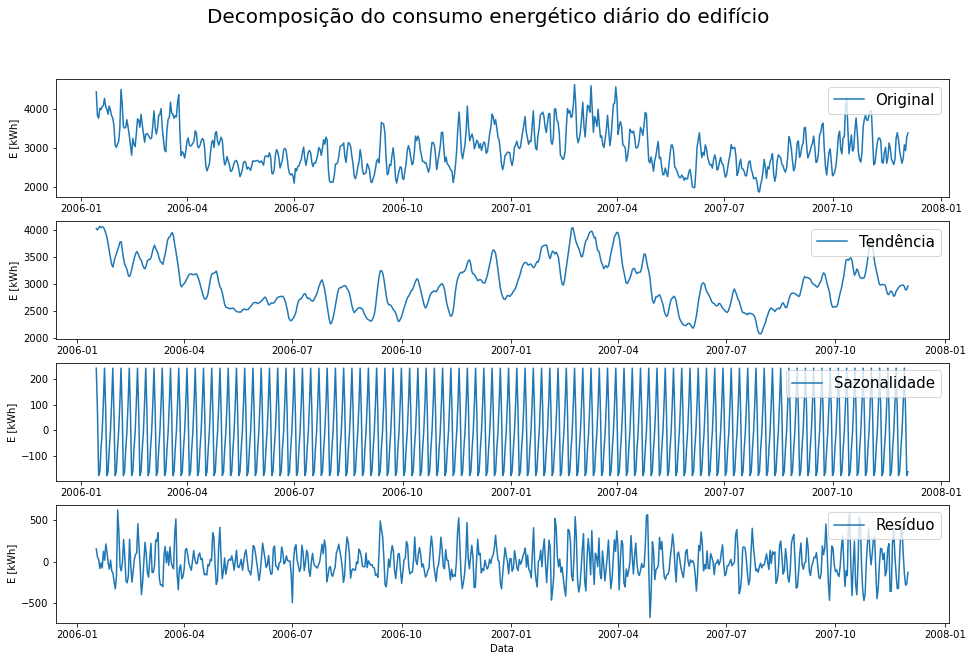

In [21]:
# Analisando o modelo estrutural do consumo
decomposition = seasonal_decompose(df_electric, model='additive')

# define componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Setting the plot
fig, axs = plt.subplots(4,1, figsize=(16,10))
fig.suptitle("Decomposição do consumo energético diário do edifício", fontsize=20)

axs[0].plot(df_electric, label='Original')
axs[0].set_ylabel("E [kWh]")
axs[0].legend(fontsize=15, loc='upper right')

axs[1].plot(trend, label='Tendência')
axs[1].set_ylabel("E [kWh]")
axs[1].legend(fontsize=15, loc='upper right')

axs[2].plot(seasonal, label='Sazonalidade')
axs[2].set_ylabel("E [kWh]")
axs[2].legend(fontsize=15, loc='upper right')

axs[3].plot(residual, label='Resíduo')
axs[3].set_xlabel("Data")
axs[3].set_ylabel("E [kWh]")
axs[3].legend(fontsize=15, loc='upper right')

ax.grid(True)
_ = plt.show()

In [22]:
# Creating the features for the data

start_day = df_electric.index.min()
end_day = df_electric.index.max()

df_weather = pd.DataFrame(index=pd.date_range(start=start_day, end=end_day, freq="D", name='date'))
df_weather.info()

# Resampling our data into features of the model
# Dry bulb temperature
df_dry_temp = df_dry_temp_1h['dry_temp'].resample('D')
df_weather['TBS_max'] = df_dry_temp.agg(np.max)
df_weather['TBS_media'] = df_dry_temp.agg(np.mean)
df_weather['TBS_min'] = df_dry_temp.agg(np.min)

# Wet bulb temperature
df_wet_temp = df_wet_temp_1h['wet_temp'].resample('D')

df_weather['TBU_max'] = df_wet_temp.agg(np.max)
df_weather['TBU_media'] = df_wet_temp.agg(np.mean)
df_weather['TBU_min'] = df_wet_temp.agg(np.min)

# Humidity
df_humid = df_humid_1h['humidity'].resample('D')
df_weather['Umidade_max'] = df_humid.agg(np.max)
df_weather['Umidade_media'] = df_humid.agg(np.mean)
df_weather['Umidade_min'] = df_humid.agg(np.min)


# Wind
df_wind = df_wind_1h.resample('D')
df_weather['Vel_vento_max'] = df_wind['wind_vel'].agg(np.max)
df_weather['Vel_vento_media'] = df_wind['wind_vel'].agg(np.mean)
df_weather['Vel_vento_min'] = df_wind['wind_vel'].agg(np.min)

# df_weather['Direcao_vento'] = df_wind['wind_dir'].agg(lambda x:x.value_counts().index[0])
# Adding the most frequent wind direction of the day
# df_weather = pd.get_dummies(df_weather,
#                           columns=['Direcao_vento'])

# Radiation (Already with 1d samples)
df_weather = df_weather.merge(df_rad_1d[['radiation']], how='left', on='date')

df_weather = df_weather.rename(columns={'radiation':'Radiacao'})

# Adding time features
df_weather["temp"] = df_weather.index.to_pydatetime()  # Temporary auxilary column

import holidays

sp_holidays = []

for date in sorted(holidays.Brazil(state='SP', years=[2006,2007,2008])):
    sp_holidays.append(date)

df_weather["Holiday"] = df_weather['temp'].apply(lambda t: 1 if t.date() in sp_holidays else 0)
df_weather["Quarter"] = df_weather["temp"].apply(lambda t: t.quarter)
df_weather["Month"] = df_weather["temp"].apply(lambda t: t.month)
df_weather["WeekOfYear"] = df_weather["temp"].apply(lambda t: t.weekofyear)
df_weather["Day"] = df_weather["temp"].apply(lambda t: t.day)
df_weather["DayOfYear"] = df_weather["temp"].apply(lambda t: t.dayofyear)
df_weather["DayOfWeek"] = df_weather["temp"].apply(lambda t: t.day_of_week)
df_weather["Hour"] = df_weather["temp"].apply(lambda t: t.hour)
df_weather["IsWeekdEnd"] = df_weather["temp"].apply(lambda t: 1 if t.weekday() > 4 else 0)

df_weather = df_weather.drop(columns=["temp"])

# Adding the day of the week as one-hot variables
df_weather = df_weather.join(pd.get_dummies(df_weather.index.day_name()).set_index(df_weather.index))

# Combining Weather and Consumption data
df_weather = df_weather.join(df_electric, how='left', on='date')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 690 entries, 2006-01-14 to 2007-12-04
Freq: D
Empty DataFrame

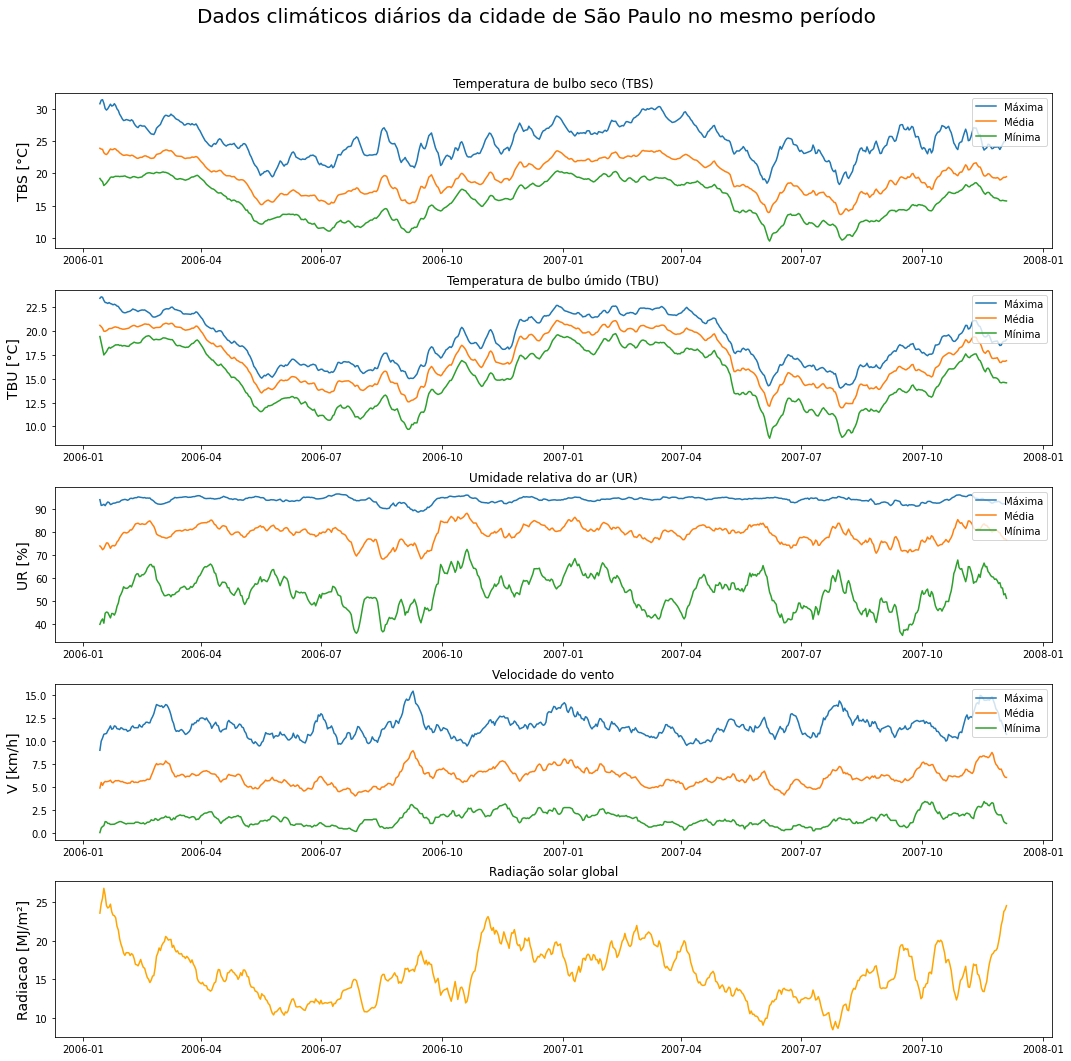

In [23]:
# Smoothing the weather
df_weather_filter = df_weather.rolling('15d').mean()

# Plotting the weather files
fig, axs = plt.subplots(5,1, figsize=(15,15))
fig.suptitle("Dados climáticos diários da cidade de São Paulo no mesmo período", fontsize=20)

axs[0].set_title("Temperatura de bulbo seco (TBS)")
axs[0].set_ylabel("TBS [°C]", fontsize=14)
axs[0].plot(df_weather_filter['TBS_max'], label='Máxima')
axs[0].plot(df_weather_filter['TBS_media'], label='Média')
axs[0].plot(df_weather_filter['TBS_min'], label='Mínima')


axs[1].set_title("Temperatura de bulbo úmido (TBU)")
axs[1].set_ylabel("TBU [°C]", fontsize=14)
axs[1].plot(df_weather_filter['TBU_max'],   label='Máxima')
axs[1].plot(df_weather_filter['TBU_media'], label='Média')
axs[1].plot(df_weather_filter['TBU_min'],   label='Mínima')


axs[2].set_title("Umidade relativa do ar (UR)")
axs[2].set_ylabel("UR [%]", fontsize=14)
axs[2].plot(df_weather_filter['Umidade_max'],   label='Máxima')
axs[2].plot(df_weather_filter['Umidade_media'], label='Média')
axs[2].plot(df_weather_filter['Umidade_min'],   label='Mínima')



axs[3].set_title("Velocidade do vento")
axs[3].set_ylabel("V [km/h]", fontsize=14)
axs[3].plot(df_weather_filter['Vel_vento_max'],   label='Máxima')
axs[3].plot(df_weather_filter['Vel_vento_media'], label='Média')
axs[3].plot(df_weather_filter['Vel_vento_min'],   label='Mínima')

axs[4].set_ylabel("Radiacao [MJ/m²]", fontsize=14)
axs[4].set_title("Radiação solar global")
axs[4].plot(df_weather_filter['Radiacao'],  color='orange')

for ax in axs[:-1]:
  ax.legend(fontsize=10, loc='upper right')


fig.tight_layout()
fig.subplots_adjust(top=0.9)
_ = plt.show()

#df_weather[['TBS_max','TBS_media', 'TBS_min']].rolling('30d').mean().plot(ax=axes[0])
#df_weather[['TBU_max','TBU_media', 'TBU_min']].rolling('30d').mean().plot(ax=axes[1])
#df_weather[['Umidade_max','Umidade_media', 'Umidade_min']].rolling('30d').mean().plot(ax=axes[2])
#df_weather[['Radiacao']].rolling('30d').mean().plot(ax=axes[3])
#df_weather[['Vel_vento_max','Vel_vento_media','Vel_vento_min']].rolling('30d').mean().plot(ax=axes[4])

In [24]:
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 690 entries, 2006-01-14 to 2007-12-04
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TBS_max          690 non-null    float64
 1   TBS_media        690 non-null    float64
 2   TBS_min          690 non-null    float64
 3   TBU_max          690 non-null    float64
 4   TBU_media        690 non-null    float64
 5   TBU_min          690 non-null    float64
 6   Umidade_max      690 non-null    int64  
 7   Umidade_media    690 non-null    float64
 8   Umidade_min      690 non-null    int64  
 9   Vel_vento_max    690 non-null    float64
 10  Vel_vento_media  690 non-null    float64
 11  Vel_vento_min    690 non-null    float64
 12  Radiacao         690 non-null    float64
 13  Holiday          690 non-null    int64  
 14  Quarter          690 non-null    int64  
 15  Month            690 non-null    int64  
 16  WeekOfYear       690 non-null    int64  
 1

Train set X (552, 29)
Train set y (552,)
Test set X (138, 29)
Test set y (138,)


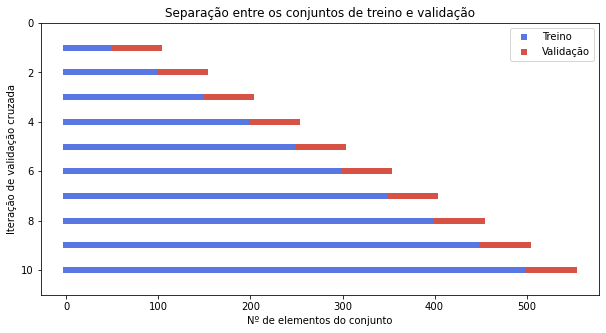

In [25]:
# separating the features from the target variable
X, y = df_weather.iloc[:, :-1], df_weather.iloc[:, -1]

X_training, X_test, y_training, y_test = train_test_split(X, y, 
                                                          test_size = 0.2, 
                                                          shuffle = False)

print("Train set X", X_training.shape)
print("Train set y", y_training.shape)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

# expanding window train-split method
# using all history to train

cv = TimeSeriesSplit(n_splits=10)

fig, ax = plt.subplots(figsize=(10, 5))
for index, (X_train, X_val) in enumerate(cv.split(X_training)):
    # Plota índices de treino e teste
    l1 = ax.scatter(X_train, [index+1] * len(X_train), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(X_val, [index+1] * len(X_val), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[11, 0], title='Separação entre os conjuntos de treino e validação', xlabel='Nº de elementos do conjunto', ylabel='Iteração de validação cruzada')
    ax.legend([l1, l2], ['Treino', 'Validação'])

In [26]:
# define os valores possíveis para os parâmetros a serem testados

# 'scale', MinMaxScaler(feature_range=(0,1))
# 'scale', MinMaxScaler(feature_range=(-0.5,0.5))
# 'scale', MinMaxScaler(feature_range=(-1,1))
# 'scale', StandardScaler()

pipe = Pipeline([
        ('scale', None),
        (('SVM', SVR()))
])

SVM_C_OPTIONS = np.logspace(0, 3, 6)
SVM_GAMMA_OPTIONS = np.logspace(-10, -5, 6)
SVM_EPSILON_OPTIONS = np.logspace(-3, -0.5, 5)
SVM_COEF0_OPTIONS = np.linspace(-10,10,5)

scalers_to_test = [StandardScaler(),
                   MinMaxScaler(feature_range=(0,1)),
                   MinMaxScaler(feature_range=(-0.5,0.5)),
                   MinMaxScaler(feature_range=(-1,1))]

params = [
    {
        'scale': scalers_to_test,
        'SVM__kernel': ['linear', 'rbf'],
        'SVM__C': SVM_C_OPTIONS,
        'SVM__gamma': SVM_GAMMA_OPTIONS,
        'SVM__epsilon': SVM_EPSILON_OPTIONS,
    },
    {
        'scale': scalers_to_test,
        'SVM__kernel': ['poly'],
        'SVM__C': SVM_C_OPTIONS,
        'SVM__gamma': SVM_GAMMA_OPTIONS,
        'SVM__epsilon': SVM_EPSILON_OPTIONS,
        'SVM__degree': [4,5,6],
        'SVM__coef0': SVM_COEF0_OPTIONS,
    },
    {
        'scale': scalers_to_test,
        'SVM__kernel': ['sigmoid'],
        'SVM__C': SVM_C_OPTIONS,
        'SVM__gamma': SVM_GAMMA_OPTIONS,
        'SVM__epsilon': SVM_EPSILON_OPTIONS,
        'SVM__coef0': SVM_COEF0_OPTIONS,
    },
]

# xgb_model = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
#                          reg_lambda=1,
#                          min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#                          objective = 'reg:squarederror',eval_metric='rmse',
#                          nthread=4, scale_pos_weight=1, seed=27)

# objeto para grid search com GridSearchCV
grid_search = GridSearchCV(pipe, 
                           param_grid = params, 
                           return_train_score = True,
                           n_jobs=-1,
                           verbose=2,
                           scoring= 'neg_mean_squared_error',
                           cv = cv)

# treina modelo com Grid Search
grid_search.fit(X_training, y_training)

Fitting 10 folds for each of 15840 candidates, totalling 158400 fits


KeyboardInterrupt: 

In [27]:
# resultados do cv
# imprime melhor combinação de hiperparâmetros
print()
print('\n Best hyperparameters:',grid_search.best_params_)
print('\n Best score:',grid_search.best_score_)

cv_results = pd.DataFrame(grid_search.cv_results_)

# print score médio nos sets de treino e teste
print("Average Score on Training set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                             cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# print score médio nos sets de validação
print("Average Score on Validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) 

scores = [cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
          cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0]]
labels = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(labels, scores, width, color="blue")

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [59]:
# seta melhor opção baseada nos hiperparâmetros
# utiliza as melhores opções de hiperparâmetros encontrados

#model = grid_search.best_estimator_

model = Pipeline(steps=[('scale', StandardScaler()),
                        ('SVM',
                          SVR(
                              C=56.23413251903491,
                              epsilon=0.2,
                              gamma=1.778279410038923e-05,
                              kernel='linear'))]
                )

# treina modelo com os melhores hiperparâmetros
model.fit(X_training, y_training)

# Randomforest {'max_depth': 10, 'max_features': 10, 'n_estimators': 100} 
#     Average Score on Training set: 0.920 +/- 0.021
#     Average Score on Validation set: 0.295 +/- 0.225

# RandomForest {'max_depth': 15, 'max_features': 5, 'n_estimators': 100} 
#     Average Score on Training set: 0.925 +/- 0.022
#     Average Score on Validation set: 0.274 +/- 0.217

# RandomForest {'max_depth': 20, 'max_features': 10, 'n_estimators': 300}
# Average Score on Training set: 0.931 +/- 0.020
# Average Score on Validation set: 0.304 +/- 0.222

# Modelos de SVR
# Best hyperparameters: {'clf__C': 10.0, 'clf__epsilon': 0.2, 'clf__gamma': 3.981071705534969e-07, 'clf__kernel': 'linear', 'reduce_dims__n_components': 15}
# Average Score on Training set (RMSE): 282.431 +/- 15.2121
# Average Score on Validation set (RMSE): 306.922 +/- 58.646


# Best hyperparameters: {'clf__C': 5.623413251903491, 'clf__epsilon': 0.2, 'clf__gamma': 1.778279410038923e-05, 'clf__kernel': 'linear', 'reduce_dims__n_components': 15}
# Average Score on Training set: 0.676 +/- 0.078
# Average Score on Validation set: 0.312 +/- 0.212
# RMSE train: 296.5257935024073
# RMSE test: 270.13697113235565
# R2 train: 0.696
# R2 test: 0.668

# Best hyperparameters: {'clf__C': 5.623413251903491, 'clf__epsilon': 0.3, 'clf__gamma': 1e-07, 'clf__kernel': 'linear'}
# Average Score on Training set: 0.717 +/- 0.083
# Average Score on Validation set: 0.325 +/- 0.234
# MAE train: 199.2387408257675
# MAE test: 214.66025639847533
# RMSE train: 258.459910360864
# RMSE test: 285.22987359523916
# R2 train: 0.7694740946754166
# R2 test: 0.6306551407283072

# MinMax(-0.5,0.5) --> Best hyperparameters: {'clf__C': 56.23413251903491, 'clf__epsilon': 0.3, 'clf__gamma': 1e-07, 'clf__kernel': 'linear'}
# MAE train: 210.73845103183166
# MAE test: 219.8124317996793
# RMSE train: 271.4011524962518
# RMSE test: 284.175426861989
# R2 train: 0.7458110116818124
# R2 test: 0.6333809043493439

#Pipeline(steps=[('scale', MinMaxScaler(feature_range=(-1, 1))),
#                ('clf',
#                 SVR(C=3.1622776601683795, gamma=1e-07, kernel='linear'))])
# MAE train: 222.33718060913657
# MAE test: 231.26751105525744
# RMSE train: 286.52847189154494
# RMSE test:  303.65341995482595
# R2 train: 0.7166854200574831
# R2 test: 0.5814008006178533

# Pipeline(steps=[('scale', MinMaxScaler(feature_range=(-1, 1))),
#                ('clf',
#                 SVR(C=7.847599703514606, gamma=1e-07,
#                 kernel='linear'))])
# MAE train: 212.62434049183997
# MAE test: 222.61991971075892
# RMSE train: 273.8048249604926
# RMSE test:  288.14388783191157
# R2 train: 0.7412886087445201
# R2 test: 0.6230698623495481

# Best hyperparameters: {'SVM__C': 251.18864315095797, 'SVM__coef0': 10.0, 'SVM__degree': 5, 'SVM__epsilon': 0.31622776601683794, 'SVM__gamma': 1e-07, 'SVM__kernel': 'poly', 'scale': StandardScaler()}
# MAE train: 212.96250854792538
# MAE test: 222.90566175950818
# RMSE train: 273.84595578616154
# RMSE test:  288.5052931758944
# R2 train: 0.7412108759114504
# R2 test: 0.6221237378482236

# Pipeline(steps=[('scale', StandardScaler()),
#                ('SVM',
#                 SVR(C=5.623413251903491, epsilon=0.2,
#                     gamma=1.778279410038923e-05, kernel='linear'))])
# MAE train: 206.948364454166
# MAE test: 216.61476382673308
# RMSE train: 268.9152771030719
# RMSE test:  277.67513262137345
# R2 train: 0.7504461306599274
# R2 test: 0.6499613375456795

#Pipeline(steps=[('scale', StandardScaler()),
#                ('reduce_dims', PCA(n_components=20)),
#                ('SVM',
#                 SVR(C=56.23413251903491, epsilon=0.3, gamma=1e-07,
#                     kernel='linear'))])
# MAE train: 205.06141713281974
# MAE test: 218.77661395883834
# RMSE train: 268.4478404402204
# RMSE test:  278.1648396293558
# R2 train: 0.7513129408041329
# R2 test: 0.6487255946172147

# Pipeline(steps=[('scale', StandardScaler()),
#                ('reduce_dims', PCA(n_components=20)),
#                ('SVM',
#                 SVR(C=1000000.0, epsilon=0.2, gamma=1e-07, kernel='linear'))])
# MAE train: 204.8455252087709
# MAE test: 219.85339462863953
# RMSE train: 267.1748937637617
# RMSE test:  278.66810541442453
# R2 train: 0.7536658359358623
# R2 test: 0.6474533683217705

#model = Pipeline(steps=[('scale', StandardScaler()),
#                        ('SVM',
#                          SVR(
#                              C=59,
#                              epsilon=0.2,
#                              gamma=1.778279410038923e-05,
#                              kernel='linear'))]
#                )
# MAE train: 201.03311056922743
# MAE test: 215.7623422998873
# RMSE train: 263.18854682787213
# RMSE test:  277.04179332551047
# R2 train: 0.7609617889748217
# R2 test: 0.651556297899639

Pipeline(steps=[('scale', StandardScaler()),
                ('SVM',
                 SVR(C=56.23413251903491, epsilon=0.2,
                     gamma=1.778279410038923e-05, kernel='linear'))])

In [60]:
y_prediction = model.predict(X_test)

y_prediction = pd.Series(y_prediction, index=X_test.index)

print("# MAE train:", mean_absolute_error(y_training, model.predict(X_training)))
print("# MAE test:", mean_absolute_error(y_test, y_prediction))
print("# RMSE train:", mean_squared_error(y_training, model.predict(X_training), squared=False))
print("# RMSE test: ", mean_squared_error(y_test, y_prediction,squared=False))
print("# R2 train:", r2_score(y_training, model.predict(X_training)))
print("# R2 test:", r2_score(y_test, y_prediction))

# MAE train: 201.03311056922743
# MAE test: 215.7623422998873
# RMSE train: 263.18854682787213
# RMSE test:  277.04179332551047
# R2 train: 0.7609617889748217
# R2 test: 0.651556297899639


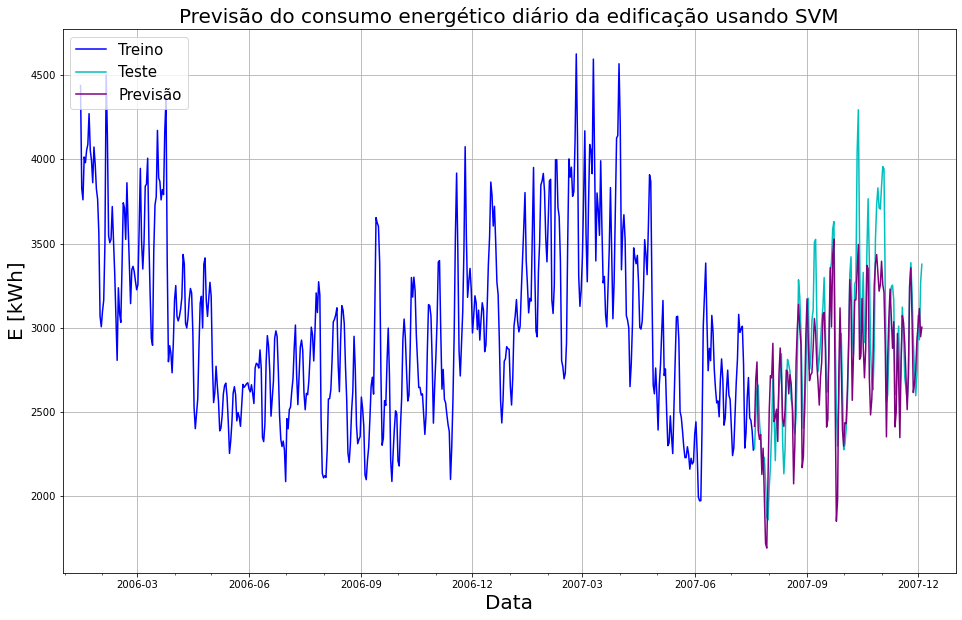

In [61]:
# PLotting the prediction values

# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=31 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
ax.plot(y_training.index, y_training, color='blue', label='Treino')
ax.plot(y_test.index, y_test, color='c', label='Teste')
ax.plot(y_prediction.index, y_prediction, color='purple', label='Previsão')


ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Previsão do consumo energético diário da edificação usando SVM", fontsize=20)

ax.legend(fontsize=15, loc='upper left')
ax.grid(True)
plt.show()

Text(0.5, 1.0, 'Dispersão do valor previsto pelo modelo SVM em relação ao real')

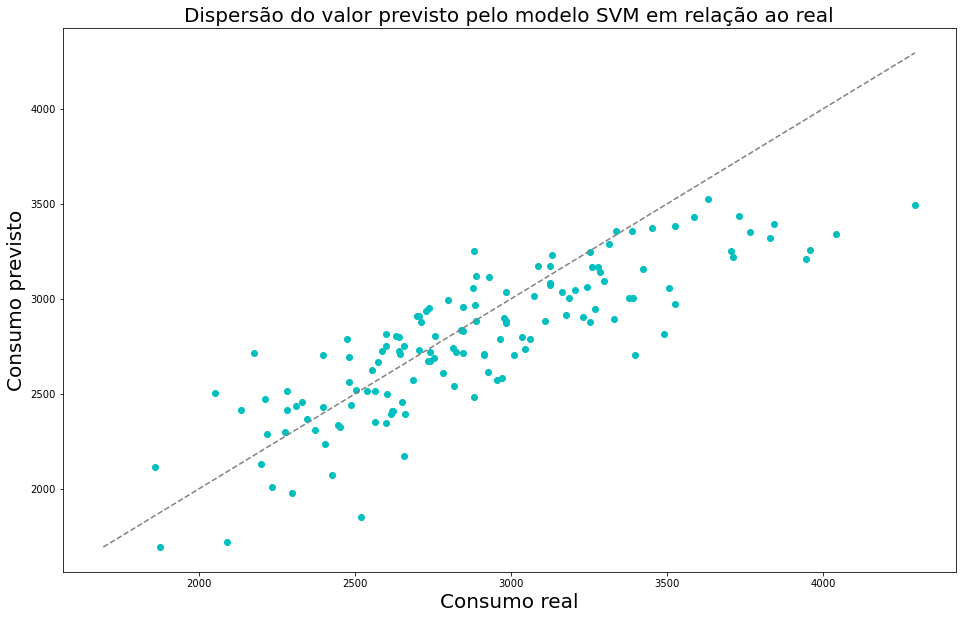

In [62]:
# PLotting the prediction values

# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

point_min = np.min([y_test, y_prediction])
point_max = np.max([y_test, y_prediction])

# Plotting data
ax.scatter(y_test, y_prediction, color='c', label='Teste')
ax.plot([point_min,point_max], [point_min,point_max], '--' ,color='grey', label='Teste')

ax.set_xlabel("Consumo real",fontsize=20)
ax.set_ylabel("Consumo previsto",fontsize=20)
ax.set_title("Dispersão do valor previsto pelo modelo SVM em relação ao real", fontsize=20)

[  78.35188267  244.55803603  128.34587827  133.95843547 -174.3938549
    1.58242383   50.72060984  -54.16035319  131.64816275   46.93390505
 -145.02183981   20.68871868   46.00414555   -7.77642207  -34.88372577
   -4.63308979  -25.68871505   33.31999845   -8.70525202   40.84629912
    0.           20.82238815   32.97294406  -28.92187499   35.7986983
   -8.9227946    12.9187866   -25.37455308  -18.29646768]


Text(0.5, 0, 'Variável')

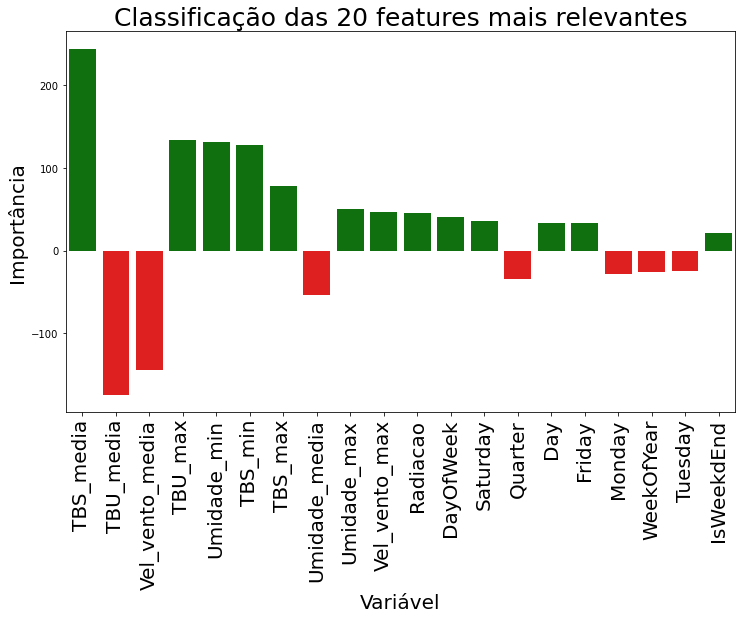

In [65]:
# Get the coefficients of each feature
coefs = model.named_steps["SVM"].coef_.flatten()

print(coefs)
# Zip coefficients and names together and make a DataFrame
zipped = zip(X.columns, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)


fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Classificação das 20 features mais relevantes", fontsize=25)
ax.set_ylabel("Importância", fontsize=20)
ax.set_xlabel("Variável", fontsize=20)